In [1]:
## Import required modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import random
from random import choices
import math
from scipy.stats import multinomial
import os

# Get the current working directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# FAP Analysis
This script combines the mutational and progression probabilities inferred from the analysis of sporadic CRC to assess the concordance between sporadic and FAP tumours. The estimated distribution of the somatic APC mutation in tumours of FAP patients with different germline mutations is comapred to data from public datasets (Sieber et al, 2002, 55 adenomas from 18 FAP patients; Miyaki et al. 2008, 86 CRCs from 23 FAP patients; Lamlum et al. 1999, 92 adenomas from 5 FAP patients).

## 1. Import FAP pubic datasets 

Note: .csv files adapted from original publicatoins to include the APC region of the germline mutation and somatic hit, where the somatic hit can also be LOH (CN-LOH and CL-LOH are both classified as LOH)

### 1.1 Lamlum 1999

Lamlum, Hanan, et al. "The type of somatic mutation at APC in familial adenomatous polyposis is determined by the site of the germline mutation: a new facet to Knudson's' two-hit'hypothesis." Nature medicine 5.9 (1999): 1071-1075.


In [2]:
LAM99 = pd.read_csv(current_dir+'/Data/FAP public data/LAMLUM.csv',delimiter='\t')

fapsL0=LAM99[LAM99['Germline Region']=='R0']
fapsL1=LAM99[LAM99['Germline Region']=='R1']

fapsL2=LAM99[LAM99['Germline Region']=='R2']
fapsL3=LAM99[LAM99['Germline Region']=='R3']

L2_s1=np.unique(fapsL1['Somatic Region'], return_counts=True)
L2_s0=np.unique(fapsL0['Somatic Region'], return_counts=True)

L2_s2=np.unique(fapsL2['Somatic Region'], return_counts=True)

print('Lamlum 1999- Germline R0:', sum(L2_s0[1]), 'adenomas from n=', len(fapsL0['Patient'].dropna()),' patients')
print('Lamlum 1999- Germline R1:', sum(L2_s1[1]), 'adenomas from n=', len(fapsL1['Patient'].dropna()),' patients')
print('Lamlum 1999- Germline R2:', sum(L2_s2[1]), 'adenomas from n=', len(fapsL2['Patient'].dropna()),' patients')



Lamlum 1999- Germline R0: 52 adenomas from n= 3  patients
Lamlum 1999- Germline R1: 18 adenomas from n= 1  patients
Lamlum 1999- Germline R2: 22 adenomas from n= 1  patients


### 1.2 Sieber 2002 

Sieber, O. M., et al. "Analysis of chromosomal instability in human colorectal adenomas with two mutational hits at APC." Proceedings of the National Academy of Sciences 99.26 (2002): 16910-16915.

In [3]:
FAPS_2002 =pd.read_csv(current_dir+'/Data/FAP public data/FAP_2002.csv',delimiter='\t')

faps20=FAPS_2002[FAPS_2002['Germline Region']=='R0']
faps21=FAPS_2002[FAPS_2002['Germline Region']=='R1']

f2_s1=np.unique(faps21['Somatic Region'], return_counts=True)
f2_s0=np.unique(faps20['Somatic Region'], return_counts=True)



print('Sieber 2002- Germline R0:', sum(f2_s0[1]), 'adenomas from n=', len(np.unique(faps20['Patient ID'])),' patients')
print('Sieber 2002- Germline R1:', sum(f2_s1[1]), 'adenomas from n=', len(np.unique(faps21['Patient ID'])),' patients')


Sieber 2002- Germline R0: 22 adenomas from n= 4  patients
Sieber 2002- Germline R1: 33 adenomas from n= 14  patients


### 1.3 Miyaki 2008 


Miyaki, Michiko, et al. "Difference in characteristics of APC mutations between colonic and extracolonic tumors of FAP patients: variations with phenotype." International journal of cancer 122.11 (2008): 2491-2497.

In [4]:

FAPS_M08 = pd.read_csv(current_dir+'/Data/FAP public data/MIYAKI_08.csv',delimiter='\t')


fapsM0=FAPS_M08[FAPS_M08['Germline Region']=='R0']
fapsM1=FAPS_M08[FAPS_M08['Germline Region']=='R1']

fapsM2=FAPS_M08[FAPS_M08['Germline Region']=='R2']
fapsM3=FAPS_M08[FAPS_M08['Germline Region']=='R3']

M2_s1=np.unique(fapsM1['Somatic Region'], return_counts=True)
M2_s0=np.unique(fapsM0['Somatic Region'], return_counts=True)

M2_s2=np.unique(fapsM2['Somatic Region'], return_counts=True)
M2_s3=np.unique(fapsM3['Somatic Region'], return_counts=True)



print('Miyaki 2008- Germline R0:', sum(M2_s0[1]), 'tumors from n=', len(np.unique(fapsM0['Patient'])),' patients')
print('Miyaki 2008- Germline R1:', sum(M2_s1[1]), 'tumors from n=', len(np.unique(fapsM1['Patient'])),' patients')

print('Miyaki 2008- Germline R2:', sum(M2_s2[1]), 'tumors from n=', len(np.unique(fapsM0['Patient'])),' patients')
print('Miyaki 2008- Germline R3:', sum(M2_s3[1]), 'tumors from n=', len(np.unique(fapsM1['Patient'])),' patients')




Miyaki 2008- Germline R0: 47 tumors from n= 11  patients
Miyaki 2008- Germline R1: 28 tumors from n= 7  patients
Miyaki 2008- Germline R2: 1 tumors from n= 11  patients
Miyaki 2008- Germline R3: 10 tumors from n= 7  patients


## 2. Calculate the predicted distribution of the second hit 

### 2.1 Mutation probabilities

In [5]:

# Import signature correction analysis for MSS (obtained using Lee-Six 2019)
IDS_corrected=pd.read_csv(parent_dir+'/Signature Analysis/Results/Indels_corrected.csv')
SBS_corrected=pd.read_csv(parent_dir+'/Signature Analysis/Results/Stops_corrected.csv')


# Find weight per region for stop_gained mutations

p0=sum(SBS_corrected['Norm probability'][SBS_corrected['Region']=='R0'])
p1=sum(SBS_corrected['Norm probability'][SBS_corrected['Region']=='R1'])
p2=sum(SBS_corrected['Norm probability'][SBS_corrected['Region']=='R2'])
p3=sum(SBS_corrected['Norm probability'][SBS_corrected['Region']=='R3'])
L=np.asarray([p0,p1,p2,p3])
L=L/sum(L)

# Find weight per region for indels 

p0=sum(IDS_corrected['Norm probability'][IDS_corrected['Region']=='R0'])
p1=sum(IDS_corrected['Norm probability'][IDS_corrected['Region']=='R1'])
p2=sum(IDS_corrected['Norm probability'][IDS_corrected['Region']=='R2'])
p3=sum(IDS_corrected['Norm probability'][IDS_corrected['Region']=='R3'])
I=np.asarray([p0,p1,p2,p3])
I=I/sum(I)

fs=3/7 # Probabilty of frameshifts, MSS 100KGP
dels=43 # Proportion of 0 20AARs with CL-LOH, MSS 100KGP
dms=25 # Proportion of 0 20AARs with double allelic truncating mutaions, MSS 100KGP
cnlohs=32 # Proportion of 0 20AARs with CN-LOH, MSS 100KGP


# Function to get the mtuation probabilities of the second hit

def NULL_secondhit(L,I,fs,dels,cnlohs):
    L0=L[0]
    L1=L[1]
    L2=L[2]
    L3=L[3]

    I0=I[0]
    I1=I[1]
    I2=I[2]
    I3=I[3]

    m0=1
    
    # relative to m0
    
    m1=(L1*fs+(1-fs)*I1) /(L0*fs+(1-fs)*I0)
    m2=(L2*fs+(1-fs)*I2 )/(L0*fs+(1-fs)*I0)
    m3=(L3*fs+(1-fs)*I3 )/(L0*fs+(1-fs)*I0)

    md=(dels/dms)*0.5
    mn=(cnlohs/dms)
    




    total=(mn+md+1+m1+m2+m3)
    t=total

    m1=m1/t
    m2=m2/t
    m0=1/t
    m3=m3/t
    mn=mn/t
    md=md/t


    m_LOH=mn+md # consider CN-LOH and CL-LOH events together
    m_0=m0
    m_1=m1
    m_2=m2
    m_3=m3
    


    # Second hits considered
    second_hit=['LOH','R0','R1','R2','R3']



    return second_hit, np.asarray([m_LOH, m_0,m_1,m_2,m_3])/sum(np.asarray([m_LOH, m_0,m_1,m_2,m_3]))


# Calculate distribution of the second hit
second_hit,second_probs=NULL_secondhit(L,I,fs,dels,cnlohs)


### 2.2 Progression probabilities

In [6]:
# Import progression probailities from 100KGP MSS analysis
null_transform = pd.read_csv(current_dir+'/Data/100KGP_MSS_Trans.csv')
progression_probabilities = null_transform['Progression']
Genotype = null_transform['Genotype']


In [7]:
# Calculate null distribution (just from mutation probabilities)
distribution_null=np.asarray(second_probs)

# Extract progression probabilities of possible genotypes for patients with germline in Region 0 
progression_G0=np.asarray([progression_probabilities[10],progression_probabilities[0],progression_probabilities[4],progression_probabilities[7],progression_probabilities[9]])
distribution_G0=np.asarray(second_probs)*np.asarray(progression_G0)/ (sum(np.asarray(second_probs)*np.asarray(progression_G0)))

# Extract progression probabilities of possible genotypes for patients with germline in Region 1 
progression_G1=np.asarray([progression_probabilities[11]+progression_probabilities[15],progression_probabilities[4],progression_probabilities[1],progression_probabilities[5],progression_probabilities[6]])
distribution_G1=np.asarray(second_probs)*np.asarray(progression_G1)/ (sum(np.asarray(second_probs)*np.asarray(progression_G1)))

# Extract progression probabilities of possible genotypes for patients with germline in Region 2 
progression_G2=np.asarray([progression_probabilities[12]+progression_probabilities[16],progression_probabilities[7],progression_probabilities[5],progression_probabilities[2],progression_probabilities[8]])
distribution_G2=np.asarray(second_probs)*np.asarray(progression_G2)/ (sum(np.asarray(second_probs)*np.asarray(progression_G2)))

# Extract progression probabilities of possible genotypes for patients with germline in Region 3
progression_G3=np.asarray([progression_probabilities[13]+progression_probabilities[17],progression_probabilities[9],progression_probabilities[6],progression_probabilities[8],progression_probabilities[3]])
distribution_G3=np.asarray(second_probs)*np.asarray(progression_G3)/ (sum(np.asarray(second_probs)*np.asarray(progression_G3)))


## 3. Find CI and plot results

In [8]:
# Function to simulate from multinomial distribution to determine 95% CI

def CI(sample_size, dist):
    trial=multinomial.rvs(sample_size, dist, size=1000, random_state=None)/sample_size
    mean=np.mean(trial,axis=0)
    clow=np.quantile(trial, 0.025,axis=0)
    chigh=np.quantile(trial, 0.975,axis=0)
    return mean, clow, chigh

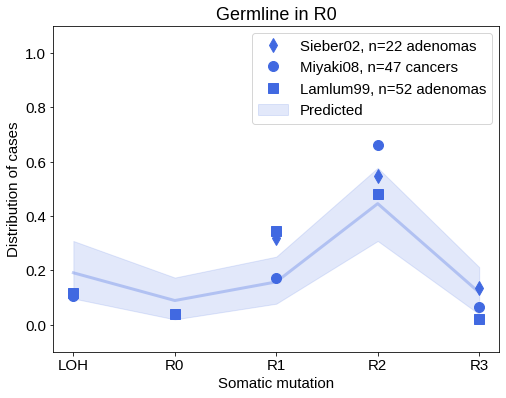

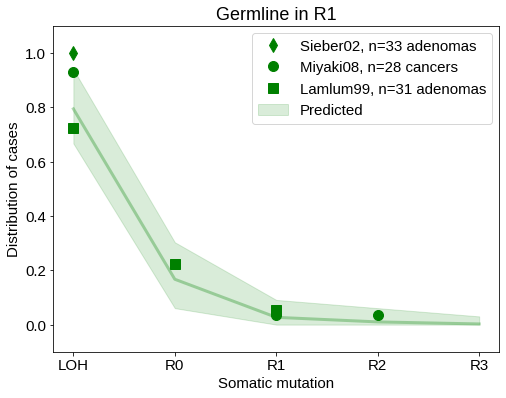

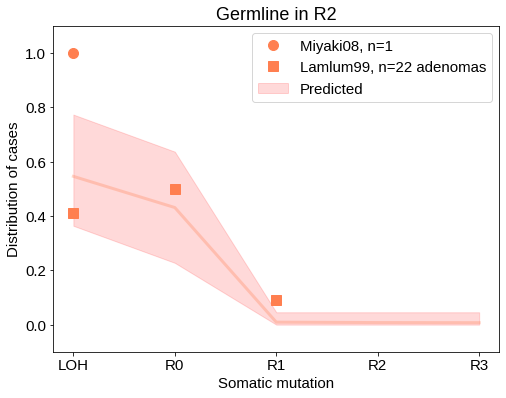

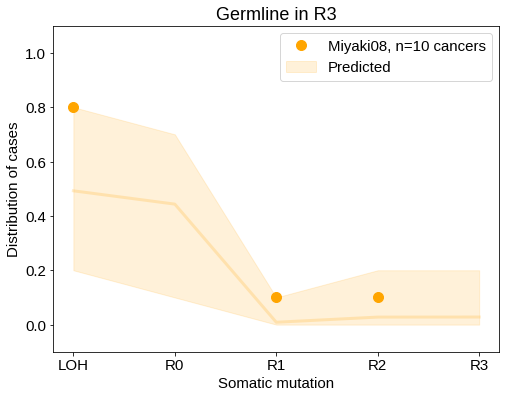

In [9]:
# Plot results (Figure 7)


# For Germline R0

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

probabilities=distribution_G0
sample_size=52
m,cl,ch=CI(sample_size, probabilities)
dist_preu0=cl
dist_pred0=ch
plt.plot(second_hit,distribution_null,'--',color='grey',alpha=0)#,label='Predicted null ')
plt.plot(f2_s0[0],f2_s0[1]/sum(f2_s0[1]),'d',markersize=10,color='royalblue',label='Sieber02, n=22 adenomas')
plt.plot(M2_s0[0],M2_s0[1]/sum(M2_s0[1]),'o',markersize=10,color='royalblue',label='Miyaki08, n=47 cancers')
plt.plot(L2_s0[0],L2_s0[1]/sum(L2_s0[1]),'s',markersize=10,color='royalblue',label='Lamlum99, n=52 adenomas')


plt.xlabel('Somatic mutation')
plt.ylabel('Distribution of cases')
plt.title('Germline in R0')

plt.ylim([-0.1,1.1])
plt.plot(second_hit, distribution_G0,color='royalblue', linewidth=3,alpha=0.3)
plt.fill_between(second_hit, dist_pred0, dist_preu0,color='royalblue',alpha=0.15,label='Predicted')
plt.legend()
plt.savefig(current_dir+'/Results/R0.svg',dpi=300)


# For Germline R1

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'


probabilities=distribution_G1
sample_size=33
m,cl,ch=CI(sample_size, probabilities)
dist_preu1=cl
dist_pred1=ch
plt.plot(second_hit,distribution_null,'.',color='white',alpha=0)#label='Predicted null ')

plt.plot(f2_s1[0],f2_s1[1]/sum(f2_s1[1]),'d',markersize=10,color='green',label='Sieber02, n=33 adenomas')
plt.plot(M2_s1[0],M2_s1[1]/sum(M2_s1[1]),'o',markersize=10,color='green',label='Miyaki08, n=28 cancers')

plt.xlabel('Somatic mutation')
plt.ylabel('Distribution of cases')
plt.title('Germline in R1')
plt.plot(L2_s1[0],L2_s1[1]/sum(L2_s1[1]),'s',markersize=10,color='green',label='Lamlum99, n=31 adenomas')

plt.ylim([-0.1,1.1])
plt.plot(second_hit, distribution_G1,color='green', linewidth=3,alpha=0.3)
plt.fill_between(second_hit, dist_pred1, dist_preu1,color='green',alpha=0.15,label='Predicted')# distribution for germline R1')#, where=None, interpolate=False, step=None, *, data=None, **kwargs)
plt.legend()
plt.savefig(current_dir+'/Results/R1.svg',dpi=300)
plt.show()


# For Germline R2

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'


probabilities=distribution_G2
sample_size=22
plt.plot(second_hit,distribution_null,'--',color='grey',alpha=0)#,label='Predicted null ')
plt.plot(M2_s2[0],M2_s2[1]/sum(M2_s2[1]),'o',markersize=10,color='coral',label='Miyaki08, n=1')

m,cl,ch=CI(sample_size, probabilities)
dist_preu2=cl
dist_pred2=ch

m,cl,ch=CI(sample_size, probabilities)
dist_preu3=cl
dist_pred3=ch
plt.plot(L2_s2[0],L2_s2[1]/sum(L2_s2[1]),'s',markersize=10,color='coral',label='Lamlum99, n=22 adenomas')
plt.xlabel('Somatic mutation')
plt.ylabel('Distribution of cases')

plt.title('Germline in R2')

plt.ylim([-0.1,1.1])
plt.plot(second_hit, distribution_G2,color='coral', linewidth=3,alpha=0.3)#,label='Predicted distribution for germline R0')#, CI=90')#, where=None, interpolate=False, step=None, *, data=None, **kwargs)
plt.fill_between(second_hit, dist_pred2, dist_preu2,color='red',alpha=0.15,label='Predicted')#,label='Predicted distribution for germline R2')#, where=None, interpolate=False, step=None, *, data=None, **kwargs)
plt.legend()
plt.savefig(current_dir+'/Results/R2.svg',dpi=300)
plt.show()

# For Germline R3

plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.plot(second_hit,distribution_null,'--',color='grey',alpha=0)#,label='Predicted null ')

plt.ylabel('Distribution of somatic mutation')

plt.xlabel('Somatic mutation')
plt.ylabel('Distribution of cases')

plt.plot(M2_s3[0],M2_s3[1]/sum(M2_s3[1]),'o',markersize=10,color='orange',label='Miyaki08, n=10 cancers')

probabilities=distribution_G3
sample_size=10

m,cl,ch=CI(sample_size, probabilities)
dist_preu3=cl
dist_pred3=ch

plt.title('Germline in R3')
plt.xlabel('Somatic mutation')
plt.ylabel('Distribution of cases')
plt.ylim([-0.1,1.1])
plt.plot(second_hit, distribution_G3,color='orange', linewidth=3,alpha=0.2)#,label='Predicted distribution for germline R0')#, CI=90')#, where=None, interpolate=False, step=None, *, data=None, **kwargs)
plt.fill_between(second_hit, dist_pred3, dist_preu3,color='orange',alpha=0.15,label='Predicted') #distribution for germline R2')#, where=None, interpolate=False, step=None, *, data=None, **kwargs)
plt.legend()
plt.savefig(current_dir+'/Results/R3.svg',dpi=300)
